In [ ]:
import networkx as nx
import numpy as np
import pandas as pd

!pip install python-louvain

import community
import matplotlib.pyplot as plt

In [ ]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
#Method for reading the input file as a graph
def read_network(data):
    g = nx.read_edgelist(data, create_using=nx.Graph())
    return g

#Method for reading the true communities
def read_true_community(data):
    with open(data) as f:
        c = [line.rstrip().split('\t') for line in f]
    return c

In [ ]:
#Sub method for calculating the modularity for a community
#g is the graph and coms is the community 
def community_modularity(coms, g):
    if type(g) != nx.Graph:
        raise TypeError("Bad graph type, use only non directed graph")
    inc = 0
    deg = 0
    links = g.size()
    if links == 0:
        raise ValueError("A graph without link has an undefined modularity")

    for node in g:
        if node not in coms:
            continue
        com = coms[node]
        deg += g.degree(node)
        for neighbor, dt in g[node].items():
            if neighbor not in coms:
                continue
            if neighbor == node:
                # YOUR CODE HERE
                pass
            else:
                inc += 1

    m = g.size()

    # YOUR CODE HERE
    return ( (inc / (2 * m)) - (deg / (2 * m)) ** 2 )


#Method for calculating the modularity for a community
#g is the graph and coms is the community 
def modularity(g, coms):
    part = {}
    ids = 0
    for n in coms:
        part[n] = ids
    mod = community_modularity(part, g)
    return mod

In [ ]:
#Method for calculating the density
# coms is the community
def density(coms):
    ms = coms.number_of_edges()
    ns = len(coms.nodes())

    den = 2 * ms / ( ns * (ns - 1) )

    return den

In [ ]:
#Method for calculating the cut ratio
#g is the graph and coms is the community 
def cut_ratio(g, coms):
    ns = len(coms.nodes())
    total_num_nodes = int(g.number_of_nodes())
    edges_outside = 0.0
    for n in coms.nodes():
    	# YOUR CODE HERE
        for neighbor, dt in g[n].items():
            if neighbor not in coms: edges_outside += 1
 
    try:
        # YOUR CODE HERE
        ratio = edges_outside / ( ns * (total_num_nodes - ns) )
    except:
        print('Exception occured!')
        return 0
    return ratio

In [ ]:
#Method for summarizing the quality of the partitions
def pquality_summary(graph, partition):
    #mods = modularities
    #dens = densities
    #crs = cut ratios
    mods, dens, crs = [], [], []
    for cs in partition:
        if len(cs) > 1:
            community = graph.subgraph(cs)
            mods.append(modularity(graph, community))
            dens.append(density(community))
            crs.append(cut_ratio(graph, community))
            # Uncomment the next 4 lines for the sanity check:
            if cs == partition[0]:
               print(mods[-1])
               print(crs[-1])
               print(dens[-1])

    return [mods, crs, dens]

In [ ]:
file_id = '1DOHlo9t23TGmm5IR9Tp7dXHNqqNxTf68' # youtube_community_top1000.txt
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('youtube_community_top1000.txt')

file_id = '1FYh1sNvQbCB8EiMKhstgamCA4eg7Mjuf' # youtube_net.txt
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('youtube_net.txt')

#Read the network graph and the communities
G = read_network('youtube_net.txt')
C = read_true_community("youtube_community_top1000.txt")

In [ ]:
# Calculate partition qualities
len_C = np.array([len(x) for x in C])
partition = C
mods, crs, dens = pquality_summary(G, partition)

2.1480581525602118e-05
0.00013937984765946497
0.036210317460317464


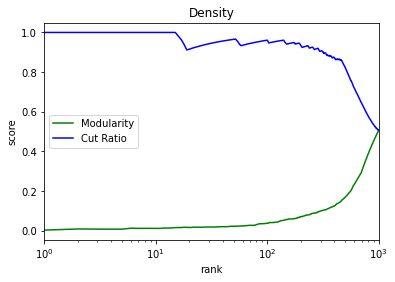

In [ ]:
#Sort the obtained scores
mods_sort, den_sort_mods = zip(*sorted(zip(mods, dens), reverse=True))
crs_sort, den_sort_crs = zip(*sorted(zip(crs, dens), reverse=False))
den_sort_mods_avg = [np.mean(den_sort_mods[0:(i+1)]) for i in range(len(den_sort_mods))]
den_sort_crs_avg = [np.mean(den_sort_crs[0:(i+1)]) for i in range(len(den_sort_crs))]

#Code for creating the plot
ax = plt.gca()
ax.set_xlim(10**0, 10**3)
ax.set_xscale('log')
ax.plot(np.array([i for i in range(1000)]), np.array(den_sort_mods_avg), color='green', label='Modularity')
ax.plot(np.array([i for i in range(1000)]), np.array(den_sort_crs_avg), color='blue', label='Cut Ratio')
plt.title('Density')
plt.legend()
plt.xlabel('rank')
plt.ylabel('score')
plt.savefig("density.jpg")